# Boost and Rotate

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from ptetaphi_nn import PtEtaPhiNN
import tools
from keras.models import Sequential
from keras.layers import Dense, Dropout
with open("/home/cmccracken/start_tf/bbb/filepath.txt", 'r') as f:
    filename = f.read()

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


In [3]:
print("filtering from", len(s_table), "total events")

# filter so we get events with 3 or 4 b-jets, and 3 tags
b34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nt3 = s_table.nbtags==3  # 3 b-tags
events = s_table[b34 & nt3]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]

n_events = len(events)
print(n_events)

filtering from 777150 total events
303925


In [4]:
cutoff = 10
# pad events out to 'cutoff' events
events = tools.pad(events, cutoff)
# boost/rotate
events = tools.boost_and_rotate(events)

/usr/local/lib/python3.6/dist-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 21)                462       
_________________________________________________________________
dense_9 (Dense)              (None, 700)               15400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)              

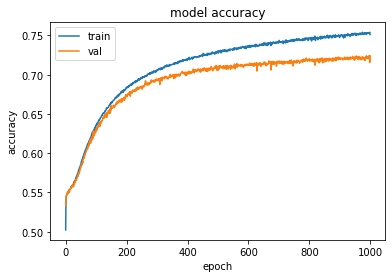

In [5]:
nn = PtEtaPhiNN(events)
nn.model = Sequential([
    Dense(3*(cutoff-3), input_dim=3*(cutoff-3), kernel_initializer='normal', activation='relu'),
    Dense(700, activation='relu'),
    Dropout(0.1),
    Dense(500, activation='relu'),
    Dropout(0.1),
    Dense(300, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense( 50, activation='relu'),
    Dense(8, kernel_initializer='normal', activation='softmax')])
nn.model.compile(loss='categorical_crossentropy',
                 optimizer="adam", metrics=['acc'])
nn.model.summary()
nn.learn(epochs=1000)

using data given when this model was created


100%|██████████| 60785/60785 [00:00<00:00, 96587.66it/s]


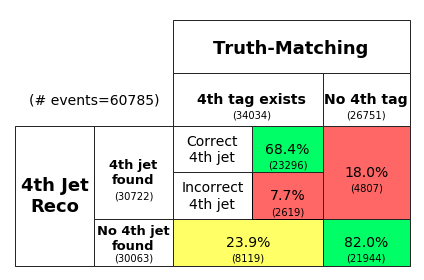

In [9]:
nn.evaluate(savename="boost_and_rotate_big")

/usr/local/lib/python3.6/dist-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!
using different data than when this model was created


100%|██████████| 777150/777150 [00:04<00:00, 190840.80it/s]


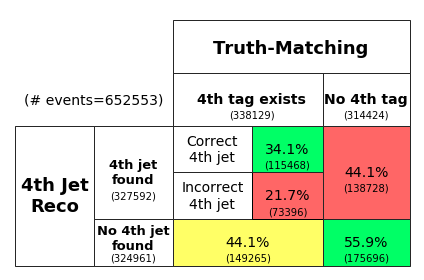

In [7]:
# evaluate on the set with >=4 jets, not ==4

# not sure if this is what we need, or the one above... Should ask
events2 = s_table[s_table.njets>=4 & nt3]
events2 = tools.pad(events2, length=cutoff)
events2 = tools.boost_and_rotate(events2)
nn.evaluate(events2)

In [10]:
# get the architecture as a json string
arch = nn.model.to_json()
# save the architecture string to a file somehow, the below will work
with open('architecture_4b.json', 'w') as arch_file:
    arch_file.write(arch)
# now save the weights as an HDF5 file
nn.model.save_weights('weights_4b.h5')